In [0]:
# Import required libraries
import torch
from torchtext import data
from torchtext import datasets
import random
import numpy as np
import torch.nn as nn
from torch.nn import MaxPool1d
from torch.nn.functional import relu

# Set random seed=2003
SEED = 2003

TEXT = data.Field(tokenize = 'spacy', batch_first = True,fix_length=50,stop_words='en')
LABEL = data.LabelField(dtype = torch.float)
fields = [('PhraseId',None),('SentimentId',None),('Phrase',TEXT),('Sentiment',LABEL)]


# Load the dataset
training_data=data.TabularDataset( '/content/drive/My Drive/Colab Notebooks/train.tsv', format = 'tsv',fields =fields,skip_header = True)

# Split the dataset into training and testinng sets
train_data, test_data = training_data.split(split_ratio=0.3, random_state = random.seed(SEED))  

In [2]:
next(iter(training_data))

In [3]:
import pandas as pd
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/train.tsv", sep='\t')
df.iloc[0:5]

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


Text(0, 0.5, 'Frequency')

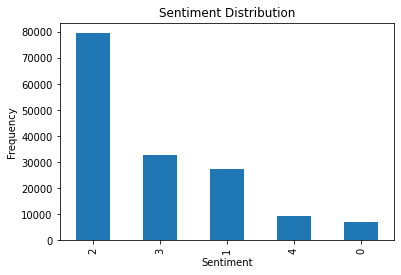

In [4]:
df['Sentiment'].value_counts()
ax = pd.value_counts(df['Sentiment']).plot(kind="bar",title = 'Sentiment Distribution')
ax.set_xlabel("Sentiment")
ax.set_ylabel("Frequency")

In [5]:
# Mount with the google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#initialize glove embeddings and build vocabulary
TEXT.build_vocab(train_data,test_data,min_freq=3,vectors = "glove.6B.100d")  
MAX_VOCAB_SIZE = 10_000

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:28, 2.22MB/s]                          
100%|█████████▉| 399169/400000 [00:23<00:00, 17392.76it/s]

In [18]:
#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",LABEL.vocab.itos)

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))    

Size of TEXT vocabulary: 16768
Size of LABEL vocabulary: ['2', '3', '1', '4', '0']
[('the', 46965), (',', 42006), ('a', 33635), ('of', 32639), ('and', 32066), ('-', 23075), ('to', 22676), ('.', 17688), ("'s", 16971), ('in', 13775)]


In [0]:
# define the batch size
BATCH_SIZE = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create PyTorch iterators to use in training/testing
train_iterator = data.BucketIterator(
    train_data, 
    batch_size = BATCH_SIZE,
    device = device)
test_iterator=data.BucketIterator(
    test_data, 
    batch_size = BATCH_SIZE,
    device = device)

In [0]:

class CNN_Text(nn.Module):
    ''' Define network architecture and forward path. '''
    def __init__(self, vocab_size, 
                 vector_size, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        # Create word embeddings from the input words     
        self.embedding = nn.Embedding(vocab_size, vector_size, 
                                      padding_idx = pad_idx)

        self.conv= nn.Conv1d(50,100,3,stride=2)

        self.conv2= nn.Conv1d(100,150,4,stride=1) 

        self.conv3= nn.Conv1d(150,200,4,stride=1) 

        self.conv4= nn.Conv1d(200,250,4,stride=1) 
        
        self.flatten = nn.Flatten()

        self.linear = nn.Linear(10000, 4096)

        self.bn1 = nn.BatchNorm1d(num_features=4096)

        self.linear2 = nn.Linear(4096,output_dim)        
        
    def forward(self, text):
        '''Forward path of the network.'''       
        # Get word embeddings and formt them for convolutions
        embedded = self.embedding(text)
        
        x = relu(self.conv(embedded))        
        
        x = relu(self.conv2(x))

        x = relu(self.conv3(x))

        x = relu(self.conv4(x))

        x = self.flatten(x)
  
        x= relu(self.linear(x))

        x = self.bn1(x)

        x = self.linear2(x)

        return x

In [0]:
# Set Input Dimention
INPUT_DIM = len(TEXT.vocab)

# Vector size (lower-dimensional repr. of each word)
EMBEDDING_DIM = 100

# Output of the linear layer (prob of a negative review)
OUTPUT_DIM = 5


In [22]:
# Zero the initial weights of the UNKnown and padding tokens.
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

# The string token used as padding. Default: “<pad>”.
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN_Text(INPUT_DIM, EMBEDDING_DIM, 
            OUTPUT_DIM, 0.5, PAD_IDX)

model.embedding.weight.data.copy_(TEXT.vocab.vectors)

# Set weights for unknown tokens as zeors
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
model = model.to(device)
model

CNN_Text(
  (embedding): Embedding(16768, 100, padding_idx=1)
  (conv): Conv1d(50, 100, kernel_size=(3,), stride=(2,))
  (conv2): Conv1d(100, 150, kernel_size=(4,), stride=(1,))
  (conv3): Conv1d(150, 200, kernel_size=(4,), stride=(1,))
  (conv4): Conv1d(200, 250, kernel_size=(4,), stride=(1,))
  (flatten): Flatten()
  (linear): Linear(in_features=10000, out_features=4096, bias=True)
  (bn1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=4096, out_features=5, bias=True)
)

In [23]:
model(next(iter(train_iterator)).Phrase).shape

torch.Size([512, 5])

In [0]:
def accuracy(preds, y):
    """ Return accuracy per batch. """

    predictions_ = preds.argmax(axis=1)
    
    correct = (predictions_ == y).float() 
    
    return correct.sum() / len(correct)


def epoch_time(start_time, end_time):
    '''Track training time. '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:
# Install libraries for accuracy measure
!pip install pytorch-ignite
from ignite.metrics import Accuracy,Precision, Recall

In [0]:


def train(model, iterator, optimizer, criterion):
    '''Train the model with specified data, optimizer, and loss function. '''
    epoch_loss = 0
    epoch_acc = 0
    prec = Precision(average=True)
    rec = Recall(average=True)
    avg_rec = 0
    avg_prec = 0
    model.train()
    
    for batch in iterator:
        
        # Reset the gradient to not use them in multiple passes 
        optimizer.zero_grad()
        
        predictions = model(batch.Phrase).squeeze(1)
        
        loss = criterion(predictions, batch.Sentiment.long())
        
        acc = accuracy(predictions, batch.Sentiment)
        
        rec.update([predictions,batch.Sentiment.long()])
        tmp_rec = rec.compute()

        prec.update([predictions,batch.Sentiment.long()])
        tmp_prec = prec.compute()
        
        # Backprop
        loss.backward()
        
        # Optimize the weights
        optimizer.step()
        
        # Record accuracy and loss
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        avg_prec += tmp_prec
        avg_rec += tmp_rec

        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), avg_prec/len(iterator), avg_rec/len(iterator)


def evaluate(model, iterator, criterion):
    '''Evaluate model performance. '''
    epoch_loss = 0
    epoch_acc = 0
    prec = Precision(average=True)
    rec = Recall(average=True)
    avg_rec = 0
    avg_prec = 0    
    # Turm off dropout while evaluating
    model.eval()
    
    # No need to backprop in eval
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.Phrase).squeeze(1)
            
            loss = criterion(predictions, batch.Sentiment.long())
            
            acc = accuracy(predictions, batch.Sentiment)
            rec.update([predictions,batch.Sentiment.long()])
            tmp_rec = rec.compute()

            prec.update([predictions,batch.Sentiment.long()])
            tmp_prec = prec.compute()            

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            avg_prec += tmp_prec
            avg_rec += tmp_rec
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), avg_prec/len(iterator), avg_rec/len(iterator)

In [0]:
from torch import optim
# Network optimizer
optimizer = optim.Adam(model.parameters())

# Loss function
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [28]:
import time
N_EPOCHS = 7

best_valid_loss = float('inf')
val_loss = []
val_acc = []
tr_loss = []
tr_acc = []

for epoch in range(N_EPOCHS):
    
    # Calculate training time
    start_time = time.time()
    
    # Get epoch losses and accuracies 
    train_loss, train_acc, avg_prec, avg_rec = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, avg_prec_val, avg_rec_val = evaluate(model, test_iterator, criterion)
    
    f1 = (2* (avg_prec*avg_rec)/(avg_prec +avg_rec))

    f1_val = (2* (avg_prec_val*avg_rec_val)/(avg_prec_val +avg_rec_val))
  
    if(epoch%3==0):
      print("Epoch " +str(epoch)+ ":\n\tTrain_Loss = " + str(train_loss)+"\n\yTrain_Accuracy = "+ str(train_acc))
      print("F1: ",f1)

      print("Epoch " +str(epoch)+ ":\n\tValid_Loss = " + str(valid_loss)+"\n\yValid_Accuracy = "+ str(valid_acc)+"\n\yTest_prec = "+ str(avg_prec_val)+"\n\yTest_rec = "+ str(avg_rec_val))
      print("F1_ val: ",f1_val)

#      print(f'Epoch: {epoch+1:2} | Epoch Time: {epoch_mins}m {epoch_secs}s')

    # end_time = time.time()
    # epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Save training metrics
    val_loss.append(valid_loss)
    val_acc.append(valid_acc)
    tr_loss.append(train_loss)
    tr_acc.append(train_acc)
    
    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'CNN-model.pt')
    
    
    # print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
   # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Epoch 0:
	Train_Loss = 1.2314662680677746
\yTrain_Accuracy = 0.5234852193490319
F1:  0.25976699052680896
Epoch 0:
	Valid_Loss = 1.1677252588985123
\yValid_Accuracy = 0.5373214493009532
\yTest_prec = 0.3825407169269799
\yTest_rec = 0.3449924773124782
F1_ val:  0.36279765830751315
Epoch 3:
	Train_Loss = 0.7906399900498597
\yTrain_Accuracy = 0.673950054075407
F1:  0.5543123466437495
Epoch 3:
	Valid_Loss = 1.01764652745746
\yValid_Accuracy = 0.6118190068507863
\yTest_prec = 0.5440417766983191
\yTest_rec = 0.40693288153490254
F1_ val:  0.46560333853380265
Epoch 6:
	Train_Loss = 0.5557981295430142
\yTrain_Accuracy = 0.7792668154706126
F1:  0.7197980626297368
Epoch 6:
	Valid_Loss = 1.2537857171531035
\yValid_Accuracy = 0.5885275348881694
\yTest_prec = 0.48907877777948666
\yTest_rec = 0.49645129419161443
F1_ val:  0.4927374599633707


In [0]:
torch.save(model.state_dict(), '1117477_1Dconv_reg.pt')